## Business Understanding
Our task for this lab is to create our own logistic regression model which is able to classify how many Uber pickups there will be (low, medium, or high) based off of different information in our dataset. The dataset is a collection of information about Uber pickups like time and location, joined with other data such as the weather for that time and location, what borough it is in, and whether or not it was a NYC public holiday. We split our predictions up by borough because certain boroughs like Manhattan generally always have a higher volume of pickups than boroughs like the Bronx, so aggregate predictions over all of NYC would not have been very insightful. Instead, we make predictions specific to each borough, with the exception of EWR and Staten Island, which we threw out because they did not contain enough data to make accurate predictions. We denote a "high" amount of pickups as greater than half a standard deviation above the mean for that borough. A "low" amount is less than half a standard deviation below the mean for that borough. A "medium" amount is inbetween. 

Our prediction task is valuable because it gives Uber insight into the time periods where they can be most profitable, and time periods where they can save money. For example, on New Years Eve there is most likely an extreme surge in the number of rides requested. If there are not enough drivers to satisfy all of these rides, people will go to Lyft or even just hail a yellow cab. However, if they prepare for this surge by incentivising drivers with an extra percentage of the ride money, there will be more drivers to satisfy the extra rides requests. Our model's insights would help pull in more profits and increases market share compared to treating every day and location as equally profitable. In production, this model would provide the best results if it were deployed so that it would run constantly and react to changing weather conditions, social movements, etc.

In [1]:
import numpy as np

## Data Prep

In [2]:
import pandas as pd
data = pd.read_csv("./data/uber_nyc_enriched.csv")

In [3]:
data.describe()

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd
count,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000
mean,490.215903,5.984924,8.818125,47.669042,30.823065,1017.817938,0.003830,0.026129,0.090464,2.529169
std,995.649536,3.699007,2.442897,19.814969,21.283444,7.768796,0.018933,0.093125,0.219402,4.520325
min,0.000000,0.000000,0.000000,2.000000,-16.000000,991.400000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,9.100000,32.000000,14.000000,1012.500000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,6.000000,10.000000,46.000000,30.000000,1018.200000,0.000000,0.000000,0.000000,0.000000
75%,449.000000,8.000000,10.000000,64.500000,50.000000,1022.900000,0.000000,0.000000,0.050000,2.958333
max,7883.000000,21.000000,10.000000,89.000000,73.000000,1043.400000,0.280000,1.240000,2.100000,19.000000


<p> checking for nan or null values in the dataset </p>

In [4]:
data.isnull().values.any()

True

<p> We found only Borough has nan values so we remove the nan rows </p>

In [5]:
data.isnull().any()

pickup_dt    False
borough       True
pickups      False
spd          False
vsb          False
temp         False
dewp         False
slp          False
pcp01        False
pcp06        False
pcp24        False
sd           False
hday         False
dtype: bool

In [6]:
data = data.dropna()

In [7]:
data.isnull().any()

pickup_dt    False
borough      False
pickups      False
spd          False
vsb          False
temp         False
dewp         False
slp          False
pcp01        False
pcp06        False
pcp24        False
sd           False
hday         False
dtype: bool

<p> We found that most of our data didnt have much correlation except temperate and the dew point temperature. We decided to get rid of this variable becasue it seemed very similar to temperature and did not think it would impact the machine learning. </p>

In [8]:
data.corr()

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd
pickups,1.000000,0.009741,-0.008429,0.063692,0.040082,-0.015708,0.005007,-0.002821,-0.022935,-0.009676
spd,0.009741,1.000000,0.086177,-0.296126,-0.321606,-0.092761,-0.000357,0.016668,-0.010412,0.097041
vsb,-0.008429,0.086177,1.000000,0.025214,-0.231294,0.167039,-0.488407,-0.118346,0.000895,-0.047834
temp,0.063692,-0.296126,0.025214,1.000000,0.896544,-0.224537,-0.013343,-0.037295,-0.014408,-0.545558
dewp,0.040082,-0.321606,-0.231294,0.896544,1.000000,-0.311156,0.115399,0.013293,0.001519,-0.489372
slp,-0.015708,-0.092761,0.167039,-0.224537,-0.311156,1.000000,-0.089752,-0.104940,-0.134689,0.121508
pcp01,0.005007,-0.000357,-0.488407,-0.013343,0.115399,-0.089752,1.000000,0.128064,0.000997,0.000310
pcp06,-0.002821,0.016668,-0.118346,-0.037295,0.013293,-0.104940,0.128064,1.000000,0.251166,0.039943
pcp24,-0.022935,-0.010412,0.000895,-0.014408,0.001519,-0.134689,0.000997,0.251166,1.000000,0.069664
sd,-0.009676,0.097041,-0.047834,-0.545558,-0.489372,0.121508,0.000310,0.039943,0.069664,1.000000


In [9]:
del data['dewp']

<p> We made the holiday column count 1 for yes and 0 for no. </p>

In [10]:
data['hday'] = data['hday'].apply(lambda x: 0 if x=='N' else 1)

<p> We one hot encoded our boroughs becuase they were string values </p>

In [11]:
from sklearn.preprocessing import LabelEncoder
encoders = dict() 
categorical_headers = ['borough']
data['borough'] = data['borough'].str.strip()
# integer encoded variables
encoders['borough'] = LabelEncoder() # save the encoder
data['borough'+'_int'] = encoders['borough'].fit_transform(data['borough'])
# oneHotCols = pd.get_dummies(data['borough'])
# data = data.join(oneHotCols)
data

,pickup_dt,borough,pickups,spd,vsb,temp,slp,pcp01,pcp06,pcp24,sd,hday,borough_int
0,2015-01-01 01:00:00,Bronx,152,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,0
1,2015-01-01 01:00:00,Brooklyn,1519,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,1
2,2015-01-01 01:00:00,EWR,0,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,2
3,2015-01-01 01:00:00,Manhattan,5258,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,3
4,2015-01-01 01:00:00,Queens,405,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,4
5,2015-01-01 01:00:00,Staten Island,6,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,5
7,2015-01-01 02:00:00,Bronx,120,3.0,10.0,30.0,1023.0,0.0,0.0,0.0,0.0,1,0
8,2015-01-01 02:00:00,Brooklyn,1229,3.0,10.0,30.0,1023.0,0.0,0.0,0.0,0.0,1,1
9,2015-01-01 02:00:00,EWR,0,3.0,10.0,30.0,1023.0,0.0,0.0,0.0,0.0,1,2
10,2015-01-01 02:00:00,Manhattan,4345,3.0,10.0,30.0,1023.0,0.0,0.0,0.0,0.0,1,3


In [12]:
del data['borough']

### Label encoding the time of day

<p> We based our hour groups by sunrise and sunset. Night is the time when the sun is down, which on average is from 8pm to 6am. Morning is from 6am till noon. Afternoon is from noon till 5pm. Evening is from 5pm till 8pm, which is around when the sunsets. 

In [13]:
dateTest = data['pickup_dt'][0]
print(int(dateTest[11:13]))
data['time_of_day_int'] = data['pickup_dt'].apply(lambda x: 0 if (int(x[11:13]) >= 6 and int(x[11:13]) < 12) else (
                                              1 if(int(x[11:13]) >= 12 and int(x[11:13]) < 17)
                                                  else (
                                                  2 if (int(x[11:13]) >= 17 and int(x[11:13]) < 21)
                                                    else (
                                                    3 if (int(x[11:13]) >= 21 or int(x[11:13]) < 6) else -1))))
# data['time_of_day'] = data['pickup_dt'].apply(lambda x: 1 if (int(x[11:13]) >= 12 and int(x[11:13]) < 17))
# data['time_of_day'] = data['pickup_dt'].apply(lambda x: 1 if (int(x[11:13]) >= 17 and int(x[11:13]) < 21))
# data['time_of_day']  = data['pickup_dt'].apply(lambda x: 1 if (int(x[11:13]) >= 21 or int(x[11:13]) < 6))
data

1


,pickup_dt,pickups,spd,vsb,temp,slp,pcp01,pcp06,pcp24,sd,hday,borough_int,time_of_day_int
0,2015-01-01 01:00:00,152,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,0,3
1,2015-01-01 01:00:00,1519,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,1,3
2,2015-01-01 01:00:00,0,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,2,3
3,2015-01-01 01:00:00,5258,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,3,3
4,2015-01-01 01:00:00,405,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,4,3
5,2015-01-01 01:00:00,6,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,5,3
7,2015-01-01 02:00:00,120,3.0,10.0,30.0,1023.0,0.0,0.0,0.0,0.0,1,0,3
8,2015-01-01 02:00:00,1229,3.0,10.0,30.0,1023.0,0.0,0.0,0.0,0.0,1,1,3
9,2015-01-01 02:00:00,0,3.0,10.0,30.0,1023.0,0.0,0.0,0.0,0.0,1,2,3
10,2015-01-01 02:00:00,4345,3.0,10.0,30.0,1023.0,0.0,0.0,0.0,0.0,1,3,3


### Label encoding the weekday

The weekday from the pickup_dt feature has been 1 hot encoded into monday-sunday. We believe having each day as a feature will help classify & predict the number of ubers necessary at a future date

In [14]:
import datetime 
data["day_int"] = np.nan
for index, row in data.iterrows():
    if(datetime.date(int(row['pickup_dt'][0:4]),int(row['pickup_dt'][5:7]),int(row['pickup_dt'][8:10]))
       .weekday() == 0):
        data.set_value(index,'day_int',0)
    elif(datetime.date(int(row['pickup_dt'][0:4]),int(row['pickup_dt'][5:7]),int(row['pickup_dt'][8:10]))
         .weekday() == 1):
        data.set_value(index,'day_int',1)
    elif(datetime.date(int(row['pickup_dt'][0:4]),int(row['pickup_dt'][5:7]),int(row['pickup_dt'][8:10]))
         .weekday() == 2):
        data.set_value(index,'day_int',2)
    elif(datetime.date(int(row['pickup_dt'][0:4]),int(row['pickup_dt'][5:7]),int(row['pickup_dt'][8:10]))
         .weekday() == 3):
        data.set_value(index,'day_int',3)
    elif(datetime.date(int(row['pickup_dt'][0:4]),int(row['pickup_dt'][5:7]),int(row['pickup_dt'][8:10]))
         .weekday() == 4):
        data.set_value(index,'day_int',4)
    elif(datetime.date(int(row['pickup_dt'][0:4]),int(row['pickup_dt'][5:7]),int(row['pickup_dt'][8:10]))
         .weekday() == 5):
        data.set_value(index,'day_int',5)
    elif(datetime.date(int(row['pickup_dt'][0:4]),int(row['pickup_dt'][5:7]),int(row['pickup_dt'][8:10]))
         .weekday() == 6):
        data.set_value(index,'day_int',6)
# data['is_monday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 0 else 0)
# data['is_tuesday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 1 else 0)
# data['is_wednesday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 2 else 0)
# data['is_thursday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 3 else 0)
# data['is_friday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 4 else 0)
# data['is_saturday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 5 else 0)
# data['is_sunday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 6 else 0)
data

,pickup_dt,pickups,spd,vsb,temp,slp,pcp01,pcp06,pcp24,sd,hday,borough_int,time_of_day_int,day_int
0,2015-01-01 01:00:00,152,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,0,3,3.0
1,2015-01-01 01:00:00,1519,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,1,3,3.0
2,2015-01-01 01:00:00,0,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,2,3,3.0
3,2015-01-01 01:00:00,5258,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,3,3,3.0
4,2015-01-01 01:00:00,405,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,4,3,3.0
5,2015-01-01 01:00:00,6,5.0,10.0,30.0,1023.5,0.0,0.0,0.0,0.0,1,5,3,3.0
7,2015-01-01 02:00:00,120,3.0,10.0,30.0,1023.0,0.0,0.0,0.0,0.0,1,0,3,3.0
8,2015-01-01 02:00:00,1229,3.0,10.0,30.0,1023.0,0.0,0.0,0.0,0.0,1,1,3,3.0
9,2015-01-01 02:00:00,0,3.0,10.0,30.0,1023.0,0.0,0.0,0.0,0.0,1,2,3,3.0
10,2015-01-01 02:00:00,4345,3.0,10.0,30.0,1023.0,0.0,0.0,0.0,0.0,1,3,3,3.0


In [15]:
del data['pickup_dt']

<p> We found that the borough EWR averages about 2.4 pickups every 96 hours so we are getting rid of the EWR borough from our dataset. We found that the borough Staten Island averages 1.6 pickups and hour and had a max 13 pickups in an hour over 6 months so we got rid of it from our dataset. </p>

In [16]:
d1 = data.where(data['borough_int']==2)[['pickups']]
print(d1.describe())
d1 = d1.dropna()
data = data[data.borough_int != 2]
d1 = data.where(data['borough_int']==5)[['pickups']]
print(d1.describe())
d1 = d1.dropna()
data = data[data.borough_int != 5]

           pickups
count  4343.000000
mean      0.024177
std       0.160937
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000
           pickups
count  4343.000000
mean      1.601888
std       1.640451
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max      13.000000


## Making our Categories

<p> We have three cateogries of pickup traffic low, medium, high. We found these by finding the mean and standard deviation of each borough. Low is half a standard deviation below the mean and high is half a stadard deviation above the mean. Anything else is counted as a medium amount of pickups. This means that the category of low, medium, and high pickup amount depends on the borough. If we did base our categories by borough then Manhattan would always be in the high pickup amount category and Queens would always be in the low pickup amount category.  </p> 

In [17]:
Man = data[data.borough_int == 3]
Bronx = data[data.borough_int == 0]
Queens = data[data.borough_int == 4]
Brooklyn = data[data.borough_int == 1]

print(Man['pickups'].describe())
print(Bronx['pickups'].describe())
print(Queens['pickups'].describe())
print(Brooklyn['pickups'].describe())

count    4343.000000
mean     2387.253281
std      1434.724668
min         0.000000
25%      1223.500000
50%      2269.000000
75%      3293.500000
max      7883.000000
Name: pickups, dtype: float64
count    4343.000000
mean       50.667050
std        31.029223
min         0.000000
25%        29.000000
50%        46.000000
75%        66.000000
max       262.000000
Name: pickups, dtype: float64
count    4343.000000
mean      309.354824
std       154.368300
min         0.000000
25%       196.000000
50%       308.000000
75%       410.000000
max       831.000000
Name: pickups, dtype: float64
count    4343.000000
mean      534.431269
std       294.810182
min         0.000000
25%       331.500000
50%       493.000000
75%       675.000000
max      2009.000000
Name: pickups, dtype: float64


<p> Using the mean and stadard deviation of each borough to place each row of data into a category. We can see that our categories are almost fairly balanced within each borough.  </p> 

In [18]:
mstd = Man['pickups'].std()
mmean = Man['pickups'].mean()
bstd = Bronx['pickups'].std()
bmean = Bronx['pickups'].mean()
qstd = Queens['pickups'].std()
qmean = Queens['pickups'].mean()
brstd = Brooklyn['pickups'].std()
brmean = Brooklyn['pickups'].mean()
data['pickupPrediction'] = 0
for index, row in data.iterrows():
    if(row['borough_int'] == 3):
        if(row['pickups']  < (mmean - mstd/2)):
            data.set_value(index,'pickupPrediction',0)
        elif(row['pickups'] > (mmean + mstd/2)):
            data.set_value(index,'pickupPrediction',2)
        else:
            data.set_value(index,'pickupPrediction',1)
    if(row['borough_int'] == 1):
        if(row['pickups']  < (bmean - bstd/2)):
            data.set_value(index,'pickupPrediction',0)
        elif(row['pickups'] > (bmean + bstd/2)):
            data.set_value(index,'pickupPrediction',2)
        else:
            data.set_value(index,'pickupPrediction',1)
    if(row['borough_int'] == 4):
        if(row['pickups']  < (qmean - qstd/2)):
            data.set_value(index,'pickupPrediction',0)
        elif(row['pickups'] > (qmean + qstd/2)):
            data.set_value(index,'pickupPrediction',2)
        else:
            data.set_value(index,'pickupPrediction',1)
    if(row['borough_int'] == 0):
        if(row['pickups']  < (brmean - brstd/2)):
            data.set_value(index,'pickupPrediction',0)
        elif(row['pickups'] > (brmean + brstd/2)):
            data.set_value(index,'pickupPrediction',2)
        else:
            data.set_value(index,'pickupPrediction',1)
print(data['pickupPrediction'].describe())
print(data['pickupPrediction'].value_counts())

count    17372.000000
mean         0.981292
std          0.898477
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: pickupPrediction, dtype: float64
0    7177
2    6852
1    3343
Name: pickupPrediction, dtype: int64


In [19]:
data.reset_index(inplace=True, drop=True)
for index, row in data.iterrows():
    if(index < 12):
        continue
    if(data['pickupPrediction'][index-4] == 0):        
        data.set_value(index,'1hrAgo',0)
    elif(data['pickupPrediction'][index-4] == 1):        
        data.set_value(index,'1hrAgo',1)
    else:
        data.set_value(index,'1hrAgo',2)
        
    if(data['pickupPrediction'][index-8] == 0):        
        data.set_value(index,'2hrAgo',0)
    elif(data['pickupPrediction'][index-8] == 1):        
        data.set_value(index,'2hrAgo',1)
    else:
        data.set_value(index,'2hrAgo',2)
        
    if(data['pickupPrediction'][index-12] == 0):        
        data.set_value(index,'3hrAgo',0)
    elif(data['pickupPrediction'][index-12] == 1):        
        data.set_value(index,'3hrAgo',1)
    else:
        data.set_value(index,'3hrAgo',2)
data = data.iloc[12:]

In [20]:
x = data
y = data['pickupPrediction']

In [21]:
del x['pickupPrediction']
del x['pickups']

## Normalizing data

In [22]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
print(x)
x_scaled = min_max_scaler.fit_transform(x.iloc[:,0:8].values)
x_not_sclaed = x.iloc[:,8:].values
x = np.concatenate((x_scaled, x_not_sclaed), axis=1)
x = pd.DataFrame(x, columns=['spd','vsb','temp','slp','pcp01','pcp06','pcp24','sd','hday','borough_int',
                            'timeOfDay_int','day_int','1hrAgo','2hrAgo','3hrAgo'])
categorical_headers_ints = ['borough_int',
                            'timeOfDay_int','day_int','1hrAgo','2hrAgo','3hrAgo']

X_train_num = x.iloc[:,:8]

             spd   vsb  temp     slp  pcp01  pcp06  pcp24   sd  hday  \
12      5.000000  10.0  29.0  1022.0    0.0    0.0    0.0  0.0     1   
13      5.000000  10.0  29.0  1022.0    0.0    0.0    0.0  0.0     1   
14      5.000000  10.0  29.0  1022.0    0.0    0.0    0.0  0.0     1   
15      5.000000  10.0  29.0  1022.0    0.0    0.0    0.0  0.0     1   
16      5.000000  10.0  28.0  1021.8    0.0    0.0    0.0  0.0     1   
17      5.000000  10.0  28.0  1021.8    0.0    0.0    0.0  0.0     1   
18      5.000000  10.0  28.0  1021.8    0.0    0.0    0.0  0.0     1   
19      5.000000  10.0  28.0  1021.8    0.0    0.0    0.0  0.0     1   
20     10.000000  10.0  28.0  1020.7    0.0    0.0    0.0  0.0     1   
21     10.000000  10.0  28.0  1020.7    0.0    0.0    0.0  0.0     1   
22     10.000000  10.0  28.0  1020.7    0.0    0.0    0.0  0.0     1   
23     10.000000  10.0  28.0  1020.7    0.0    0.0    0.0  0.0     1   
24      9.000000  10.0  28.0  1020.5    0.0    0.0    0.0  0.0  

In [23]:
x

,spd,vsb,temp,slp,pcp01,pcp06,pcp24,sd,hday,borough_int,timeOfDay_int,day_int,1hrAgo,2hrAgo,3hrAgo
0,0.238095,1.0,0.310345,0.588462,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0
1,0.238095,1.0,0.310345,0.588462,0.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,2.0,2.0,2.0
2,0.238095,1.0,0.310345,0.588462,0.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,2.0,2.0,2.0
3,0.238095,1.0,0.310345,0.588462,0.0,0.0,0.0,0.0,1.0,4.0,3.0,3.0,2.0,1.0,2.0
4,0.238095,1.0,0.298851,0.584615,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0
5,0.238095,1.0,0.298851,0.584615,0.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,2.0,2.0,2.0
6,0.238095,1.0,0.298851,0.584615,0.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,1.0,2.0,2.0
7,0.238095,1.0,0.298851,0.584615,0.0,0.0,0.0,0.0,1.0,4.0,3.0,3.0,1.0,2.0,1.0
8,0.476190,1.0,0.298851,0.563462,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0
9,0.476190,1.0,0.298851,0.563462,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,2.0,2.0,2.0


## Cross Product On Features

We did the cross product on weekday features and the time of day features. This will help our neural network understand the important relationship between two features because they both focus on time. Our other categorical features do not share any important relationships that would make them worthwhile to cross. 

## Metric Used
<p> We believe using an f1-socre would be the best evaluation metric in our case. We care about the misclassification of our data because misclassifying an amount of ubers for an area would either lead to there being too many or few drivers. This would either result in wasting drivers time or missing out rides from uber users. F1-score takes into account the false positive and false negative, which represents both cases mentioned. We will be taking the f1-score of each class and then averaging the f1-scores. Earlier, we used this dataset for logisitc regression and found that it frequently only guessed one class. Averaging the f1-scores of each class would punish the classifier for guessing only class and limit it to an average f1-score of 33%.  </p>

## Splitting Data
We choose to use continuous test and training sets as our uber pickups were given hourly over a 6 month span. Our algorithm in the real world would be getting the data in hourly and then have to predict based off this new hourly data. We split our data into 6 folds splitting our data by the time that it occured. This represents us retraining our algorithm every month off new data. We believe that this would help avoid having to retrain the model frequently and keep up with the new season's new data. This would be crucial becuase we do not have a full year's amount of data. When we got a full year's amount of data, we would use a 12 fold split to represent each month of the year. Also, we believe it would be best for the Uber to only keep the last year's data for the model. This is because the avergage amount of uber trips could change yearly and keeping old data would drag down the means and standard deviations we computed above. Overall, we thing using a continuous time series split helps represent the model's training and usage in the real world. 

<p> The data was already in order by hour. Each four rows represented one boroughs uber and weather data. We split our data into 10 folds for training. </p>

In [24]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6)
for train_index, test_index in tscv.split(x.values,y.values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [   0    1    2 ... 2477 2478 2479] TEST: [2480 2481 2482 ... 4957 4958 4959]
TRAIN: [   0    1    2 ... 4957 4958 4959] TEST: [4960 4961 4962 ... 7437 7438 7439]
TRAIN: [   0    1    2 ... 7437 7438 7439] TEST: [7440 7441 7442 ... 9917 9918 9919]
TRAIN: [   0    1    2 ... 9917 9918 9919] TEST: [ 9920  9921  9922 ... 12397 12398 12399]
TRAIN: [    0     1     2 ... 12397 12398 12399] TEST: [12400 12401 12402 ... 14877 14878 14879]
TRAIN: [    0     1     2 ... 14877 14878 14879] TEST: [14880 14881 14882 ... 17357 17358 17359]


## Modeling With Keras

In [25]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.4'

In [26]:
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from sklearn import metrics as mt
# This returns a tensor
for train_index, test_index in tscv.split(x.values,y.values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    inputs = Input(shape=(X_train.shape[1],))

TRAIN: [   0    1    2 ... 2477 2478 2479] TEST: [2480 2481 2482 ... 4957 4958 4959]
TRAIN: [   0    1    2 ... 4957 4958 4959] TEST: [4960 4961 4962 ... 7437 7438 7439]
TRAIN: [   0    1    2 ... 7437 7438 7439] TEST: [7440 7441 7442 ... 9917 9918 9919]
TRAIN: [   0    1    2 ... 9917 9918 9919] TEST: [ 9920  9921  9922 ... 12397 12398 12399]
TRAIN: [    0     1     2 ... 12397 12398 12399] TEST: [12400 12401 12402 ... 14877 14878 14879]
TRAIN: [    0     1     2 ... 14877 14878 14879] TEST: [14880 14881 14882 ... 17357 17358 17359]


## Deep

In [27]:
from keras.layers import concatenate
# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = [] # keep track of inputs for each branch
X_ints_test = []# keep track of inputs for each branch
all_inputs = [] # this is what we will give to keras.Model inputs
all_branch_outputs = [] # this is where we will keep track of output of each branch
for train_index, test_index in tscv.split(x,y):
    embed_branches = []
    X_ints_train = [] # keep track of inputs for each branch
    X_ints_test = []# keep track of inputs for each branch
    all_inputs = [] # this is what we will give to keras.Model inputs
    all_branch_outputs = [] # this is where we will keep track of output of each branch
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( X_train[col].values )
        X_ints_test.append( X_test[col].values )

        # get the number of categories
        N = int(max(X_ints_train[-1]+1)) # same as the max(df_train[col])
        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append( inputs ) # keep track of created inputs
        xbed = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        xbed = Flatten()(xbed)
        all_branch_outputs.append(xbed)
    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train.iloc[:,:9].shape[1],),sparse=False, name='numeric'))
    xnum = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_branch_outputs.append( Dense(units=10,activation='relu', name='numeric_2')(xnum) )
    # merge the branches together
    final_branch = concatenate(all_branch_outputs, name='concat_1')
    final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)


Instructions for updating:
Colocations handled automatically by placer.


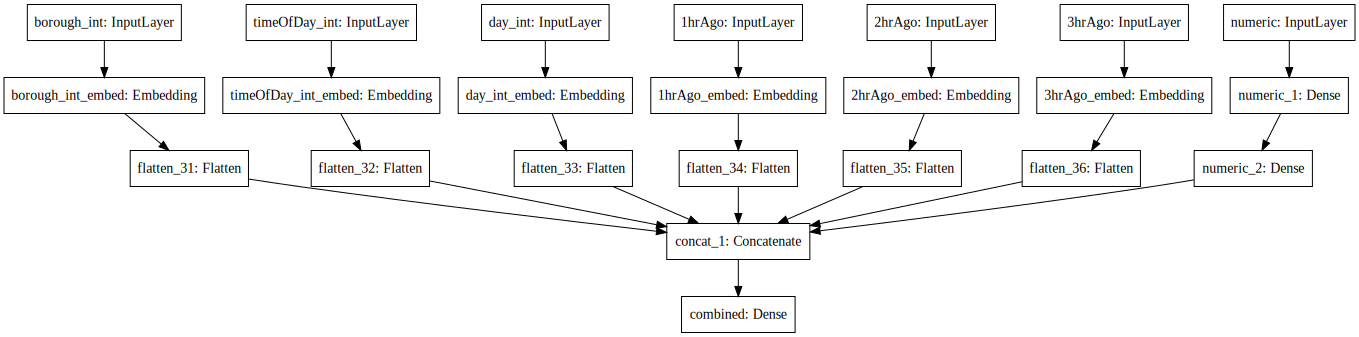

In [28]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [29]:
%%time

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_ints_train + [X_train.iloc[:,:9]], # create a list of inputs for embeddings
        y_train, epochs=10, batch_size=32, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
14880/14880 [==============================] - 1s 98us/step - loss: 0.8113 - acc: 0.1989
Epoch 2/10
14880/14880 [==============================] - 1s 59us/step - loss: 0.6531 - acc: 0.2774
Epoch 3/10
14880/14880 [==============================] - 1s 59us/step - loss: 0.5395 - acc: 0.5048
Epoch 4/10
14880/14880 [==============================] - 1s 58us/step - loss: 0.4988 - acc: 0.5109
Epoch 5/10
14880/14880 [==============================] - 1s 56us/step - loss: 0.4836 - acc: 0.5197
Epoch 6/10
14880/14880 [==============================] - 1s 59us/step - loss: 0.4756 - acc: 0.5227
Epoch 7/10
14880/14880 [==============================] - 1s 59us/step - loss: 0.4702 - acc: 0.5239
Epoch 8/10
14880/14880 [==============================] - 1s 61us/step - loss: 0.4659 - acc: 0.5289
Epoch 9/10
14880/14880 [==============================] - 1s 63us/step - loss: 0.4622 - acc: 0.5376
Epoch 10/10
14880/14880 [===========================

In [30]:
yhat = np.round(model.predict(X_ints_test + [X_test.iloc[:,:9]]))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[ 785  102    0]
 [  53  345    0]
 [   0 1195    0]] 0.45564516129032256


## Wide and Deep setup

[[1001   75    3]
 [  71  361   62]
 [   0   75  832]] f1-score: 0.857177510588078
1  months of training data


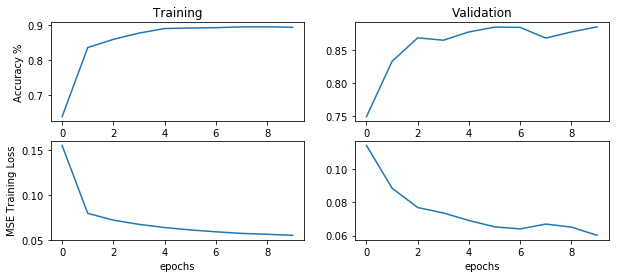

[[975  77   1]
 [ 86 385  53]
 [  4  78 821]] f1-score: 0.8559578861722349
2  months of training data


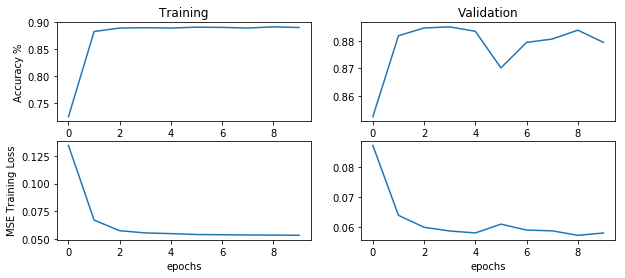

[[960  60   2]
 [ 74 402  57]
 [  1  68 856]] f1-score: 0.8733942960738322
3  months of training data


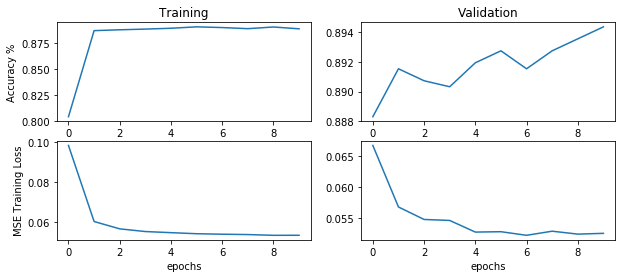

[[900  46   2]
 [ 62 389  74]
 [  1  81 925]] f1-score: 0.8701960926611111
4  months of training data


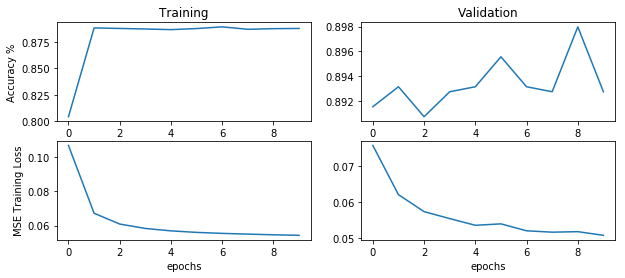

[[ 865   43   10]
 [  56  293   77]
 [   1   83 1052]] f1-score: 0.8528478934666225
5  months of training data


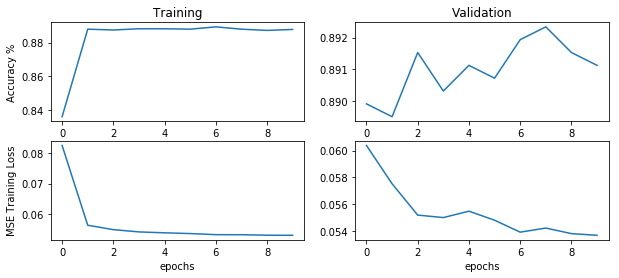

[[ 836   44    7]
 [  53  250   95]
 [   0  105 1090]] f1-score: 0.8273580939019883
6  months of training data


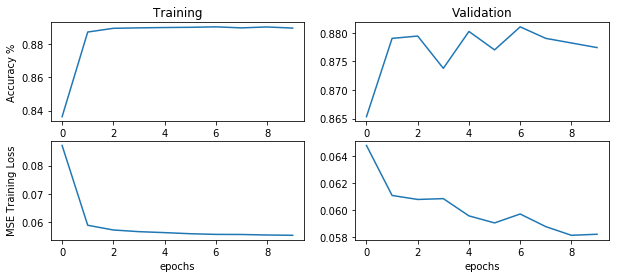

In [59]:
from keras.layers import concatenate
from matplotlib import pyplot as plt
from keras.utils.np_utils import to_categorical
%matplotlib inline
cross_columns = [['timeOfDay_int','day_int'],
                 ['1hrAgo','2hrAgo','3hrAgo']]

month = 1
for train_index, test_index in tscv.split(x,y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_Y = encoder.transform(y)
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = to_categorical(encoded_Y[train_index]), to_categorical(encoded_Y[test_index])
    # we will create separate sequential models for each embedding
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []
    for cols in cross_columns:
        # encode as ints for the embedding
        enc = LabelEncoder()
        # 1. create crossed labels by join operation
        X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x.astype('str')), axis=1)
        X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x.astype('str')), axis=1)
        # 2. encode as integers
        enc.fit(np.hstack((X_crossed_train.values, X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)

        # 3. save encodings in a list for each branch
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )
        #
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the crossed encoding
        inputs = Input(shape=(1,),dtype='int32',name='_'.join(cols))
        all_inputs.append(inputs) # save this as input for the keras.Model
        x2 = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name='_'.join(cols)+'_embed')(inputs)
        x2 = Flatten()(x2)
        #make an append and put cocatenate if we have more then one crossed feature
        all_wide_branch_outputs = x2 # save for concatenating later
        
    # merge the branches together
    wide_branch = all_wide_branch_outputs
    wide_branch = Dense(units=3,activation='sigmoid',name='wide_combined')(wide_branch)
    

    all_deep_branch_outputs = [] # this is where we will keep track of output of each branch
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( X_train[col].values )
        X_ints_test.append( X_test[col].values )

        # get the number of categories
        N = int(max(X_ints_train[-1]+1)) # same as the max(df_train[col])
        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append( inputs ) # keep track of created inputs
        xbed = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        xbed = Flatten()(xbed)
        all_deep_branch_outputs.append(xbed)
    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train.iloc[:,:9].shape[1],),sparse=False, name='numeric'))
    xnum = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( Dense(units=10,activation='relu', name='numeric_2')(xnum) )
    
    # merge the branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)

    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = Dense(units=3,activation='sigmoid',name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)
    model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])
    history = model.fit(X_ints_train + [X_train.iloc[:,:9]], # create a list of inputs for embeddings
        y_train, epochs=10, batch_size=32, verbose=0,
                       validation_data = (X_ints_test + [X_test.iloc[:,:9]], y_test))
    yhat = np.argmax(model.predict(X_ints_test + [X_test.iloc[:,:9]]),axis=1)
    print(mt.confusion_matrix(np.argmax(y_test,axis=1),yhat)
          ,'f1-score:',mt.f1_score(np.argmax(y_test,axis=1),yhat,average='macro'))
    print(month, ' months of training data')
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['acc'])
    
    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_acc'])
    plt.title('Validation')
    
    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')
    
    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.show()
    month +=1

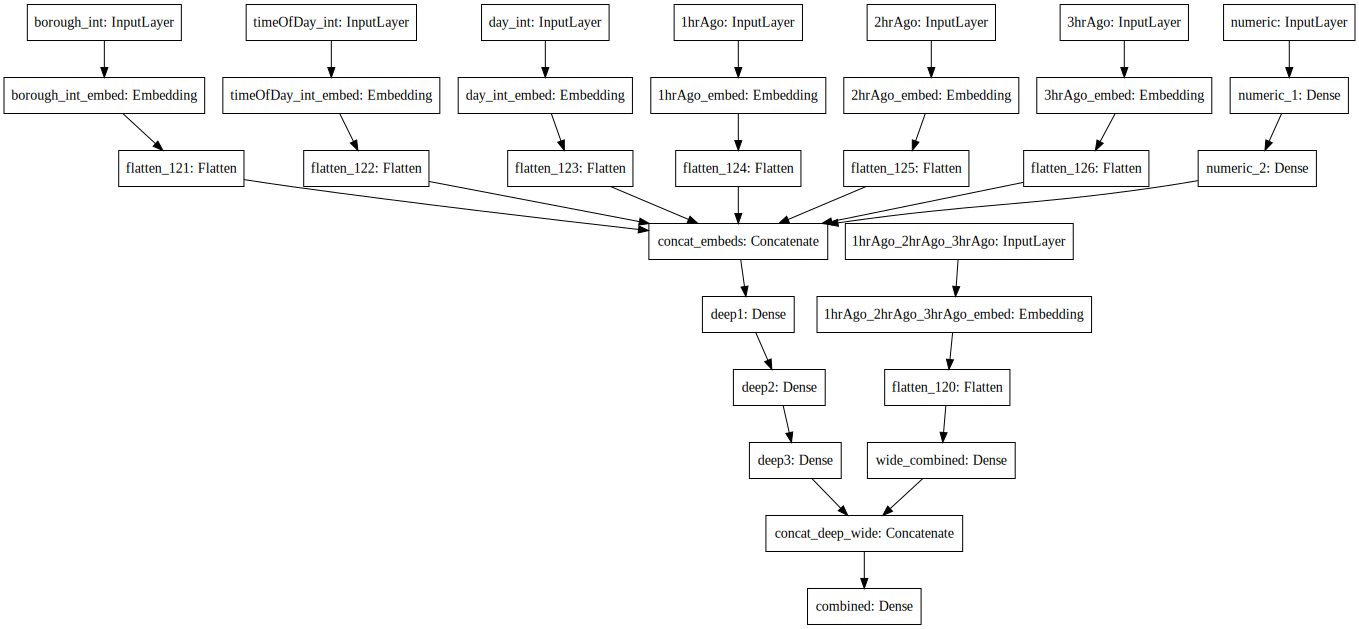

In [61]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


SVG(model_to_dot(model).create(prog='dot', format='svg'))

[[1009   70    0]
 [  89  375   30]
 [   3  148  756]] f1-score: 0.836249888428013
1  months of training data


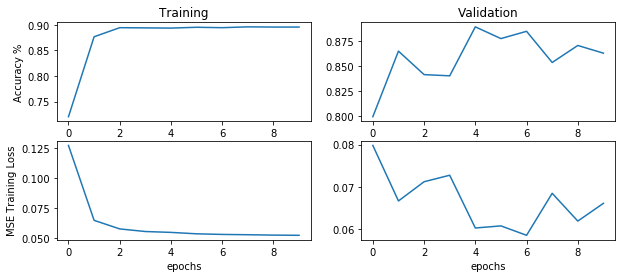

[[973  78   2]
 [ 87 381  56]
 [  3  69 831]] f1-score: 0.85714989775101
2  months of training data


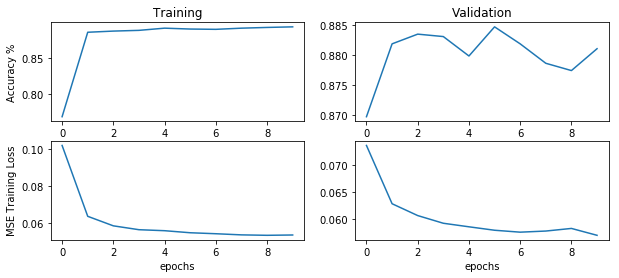

[[951  69   2]
 [ 70 405  58]
 [  0  66 859]] f1-score: 0.8725156510458031
3  months of training data


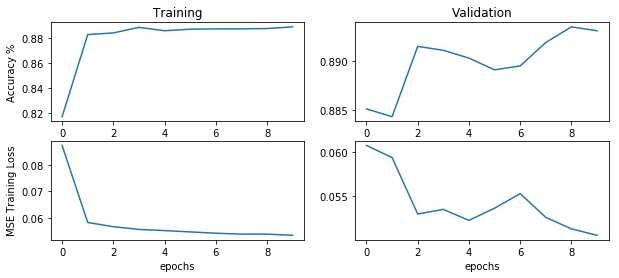

[[929  18   1]
 [ 73 390  62]
 [  2  94 911]] f1-score: 0.8770251464970341
4  months of training data


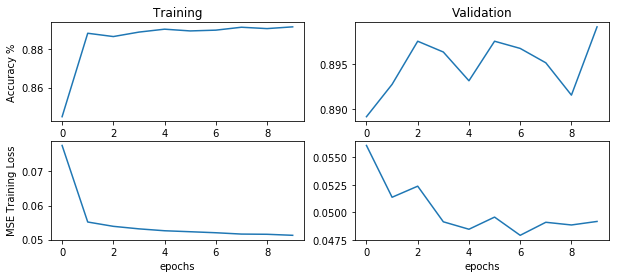

[[ 871   37   10]
 [  53  287   86]
 [   1   92 1043]] f1-score: 0.8479437791209494
5  months of training data


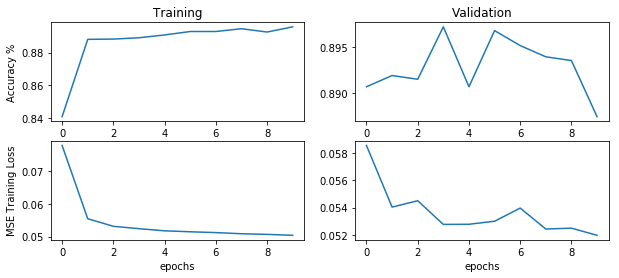

[[ 843   38    6]
 [  59  250   89]
 [   0   90 1105]] f1-score: 0.8365038581039385
6  months of training data


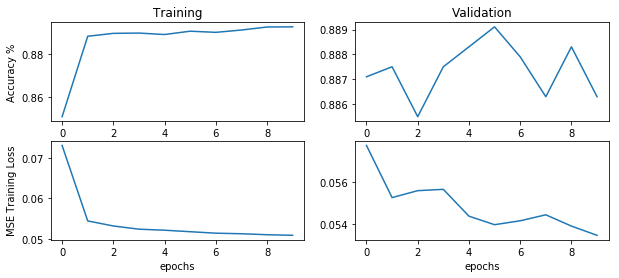

In [62]:
from keras.layers import concatenate
from matplotlib import pyplot as plt
from keras.utils.np_utils import to_categorical
%matplotlib inline
cross_columns = [['timeOfDay_int','day_int'],
                 ['1hrAgo','2hrAgo','3hrAgo']]

month = 1
for train_index, test_index in tscv.split(x,y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_Y = encoder.transform(y)
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = to_categorical(encoded_Y[train_index]), to_categorical(encoded_Y[test_index])
    # we will create separate sequential models for each embedding
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []
    for cols in cross_columns:
        # encode as ints for the embedding
        enc = LabelEncoder()
        # 1. create crossed labels by join operation
        X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x.astype('str')), axis=1)
        X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x.astype('str')), axis=1)
        # 2. encode as integers
        enc.fit(np.hstack((X_crossed_train.values, X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)

        # 3. save encodings in a list for each branch
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )
        #
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the crossed encoding
        inputs = Input(shape=(1,),dtype='int32',name='_'.join(cols))
        all_inputs.append(inputs) # save this as input for the keras.Model
        x2 = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name='_'.join(cols)+'_embed')(inputs)
        x2 = Flatten()(x2)
        #make an append and put cocatenate if we have more then one crossed feature
        all_wide_branch_outputs = x2 # save for concatenating later
        
    # merge the branches together
    wide_branch = all_wide_branch_outputs
    wide_branch = Dense(units=3,activation='sigmoid',name='wide_combined')(wide_branch)
    

    all_deep_branch_outputs = [] # this is where we will keep track of output of each branch
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( X_train[col].values )
        X_ints_test.append( X_test[col].values )

        # get the number of categories
        N = int(max(X_ints_train[-1]+1)) # same as the max(df_train[col])
        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append( inputs ) # keep track of created inputs
        xbed = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        xbed = Flatten()(xbed)
        all_deep_branch_outputs.append(xbed)
    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train.iloc[:,:9].shape[1],),sparse=False, name='numeric'))
    xnum = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( Dense(units=10,activation='relu', name='numeric_2')(xnum) )
    
    # merge the branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=100,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=75,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
    deep_branch = Dense(units=30,activation='relu', name='deep4')(deep_branch)
    deep_branch = Dense(units=20,activation='relu', name='deep5')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep6')(deep_branch)

    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = Dense(units=3,activation='sigmoid',name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)
    model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])
    history = model.fit(X_ints_train + [X_train.iloc[:,:9]], # create a list of inputs for embeddings
        y_train, epochs=10, batch_size=32, verbose=0,
                       validation_data = (X_ints_test + [X_test.iloc[:,:9]], y_test))
    yhat = np.argmax(model.predict(X_ints_test + [X_test.iloc[:,:9]]),axis=1)
    print(mt.confusion_matrix(np.argmax(y_test,axis=1),yhat)
          ,'f1-score:',mt.f1_score(np.argmax(y_test,axis=1),yhat,average='macro'))
    print(month, ' months of training data')
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['acc'])
    
    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_acc'])
    plt.title('Validation')
    
    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')
    
    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.show()
    month +=1

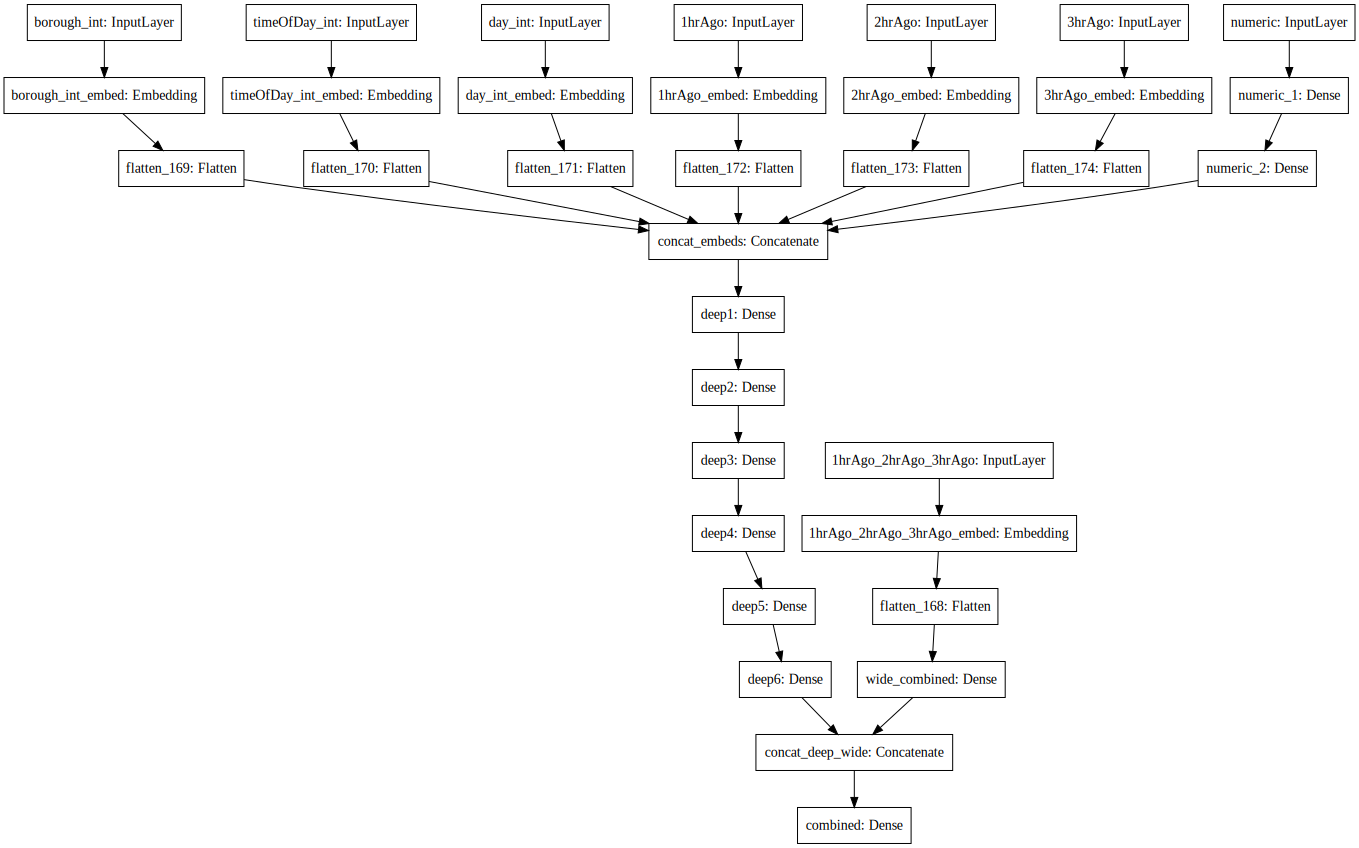

In [63]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

[[1009   54   16]
 [ 109  190  195]
 [   5   28  874]] f1-score: 0.7633443971459289
1  months of training data


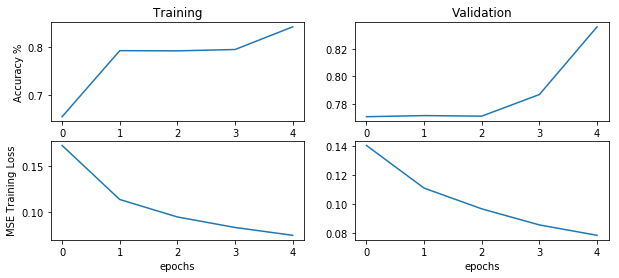

[[974  77   2]
 [ 76 389  59]
 [  2  68 833]] f1-score: 0.8626220389445601
2  months of training data


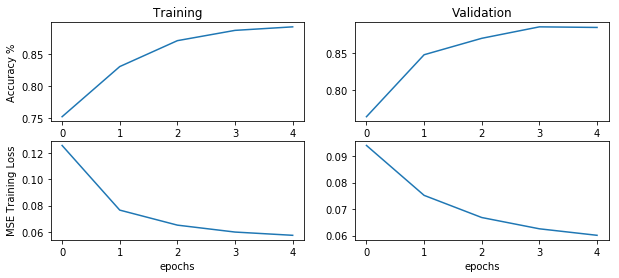

[[951  69   2]
 [ 70 409  54]
 [  0  84 841]] f1-score: 0.867059057298443
3  months of training data


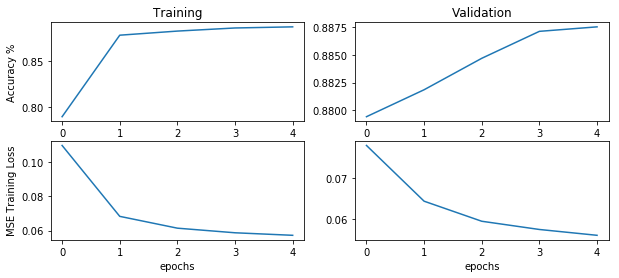

[[896  50   2]
 [ 57 397  71]
 [  1  83 923]] f1-score: 0.872130116538314
4  months of training data


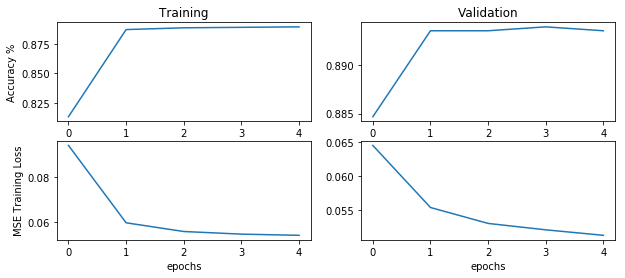

[[ 884   24   10]
 [  58  297   71]
 [   1   94 1041]] f1-score: 0.8594612681778296
5  months of training data


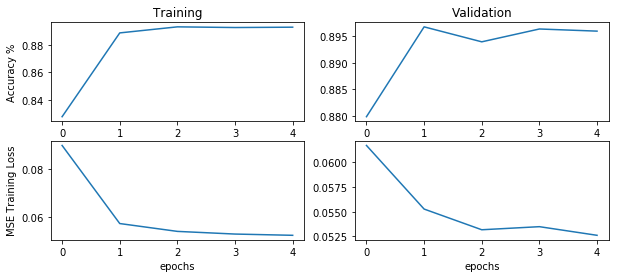

[[ 844   37    6]
 [  61  251   86]
 [   0   93 1102]] f1-score: 0.8363139816240107
6  months of training data


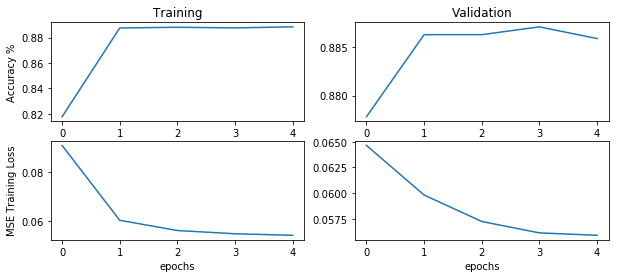

In [70]:
from keras.layers import concatenate
from matplotlib import pyplot as plt
from keras.utils.np_utils import to_categorical
%matplotlib inline
cross_columns = [['timeOfDay_int','day_int'],
                 ['1hrAgo','2hrAgo','3hrAgo']]

month = 1
for train_index, test_index in tscv.split(x,y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_Y = encoder.transform(y)
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = to_categorical(encoded_Y[train_index]), to_categorical(encoded_Y[test_index])
    # we will create separate sequential models for each embedding
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []
    for cols in cross_columns:
        # encode as ints for the embedding
        enc = LabelEncoder()
        # 1. create crossed labels by join operation
        X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x.astype('str')), axis=1)
        X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x.astype('str')), axis=1)
        # 2. encode as integers
        enc.fit(np.hstack((X_crossed_train.values, X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)

        # 3. save encodings in a list for each branch
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )
        #
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the crossed encoding
        inputs = Input(shape=(1,),dtype='int32',name='_'.join(cols))
        all_inputs.append(inputs) # save this as input for the keras.Model
        x2 = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name='_'.join(cols)+'_embed')(inputs)
        x2 = Flatten()(x2)
        #make an append and put cocatenate if we have more then one crossed feature
        all_wide_branch_outputs = x2 # save for concatenating later
        
    # merge the branches together
    wide_branch = all_wide_branch_outputs
    wide_branch = Dense(units=3,activation='sigmoid',name='wide_combined')(wide_branch)
    

    all_deep_branch_outputs = [] # this is where we will keep track of output of each branch
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( X_train[col].values )
        X_ints_test.append( X_test[col].values )

        # get the number of categories
        N = int(max(X_ints_train[-1]+1)) # same as the max(df_train[col])
        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append( inputs ) # keep track of created inputs
        xbed = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        xbed = Flatten()(xbed)
        all_deep_branch_outputs.append(xbed)
    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train.iloc[:,:9].shape[1],),sparse=False, name='numeric'))
    xnum = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( Dense(units=10,activation='relu', name='numeric_2')(xnum) )
    
    # merge the branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep2')(deep_branch)
    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = Dense(units=3,activation='sigmoid',name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)
    model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])
    history = model.fit(X_ints_train + [X_train.iloc[:,:9]], # create a list of inputs for embeddings
        y_train, epochs=10, batch_size=32, verbose=0,
                       validation_data = (X_ints_test + [X_test.iloc[:,:9]], y_test))
    yhat = np.argmax(model.predict(X_ints_test + [X_test.iloc[:,:9]]),axis=1)
    print(mt.confusion_matrix(np.argmax(y_test,axis=1),yhat)
          ,'f1-score:',mt.f1_score(np.argmax(y_test,axis=1),yhat,average='macro'))
    print(month, ' months of training data')
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['acc'])
    
    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_acc'])
    plt.title('Validation')
    
    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')
    
    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.show()
    month +=1

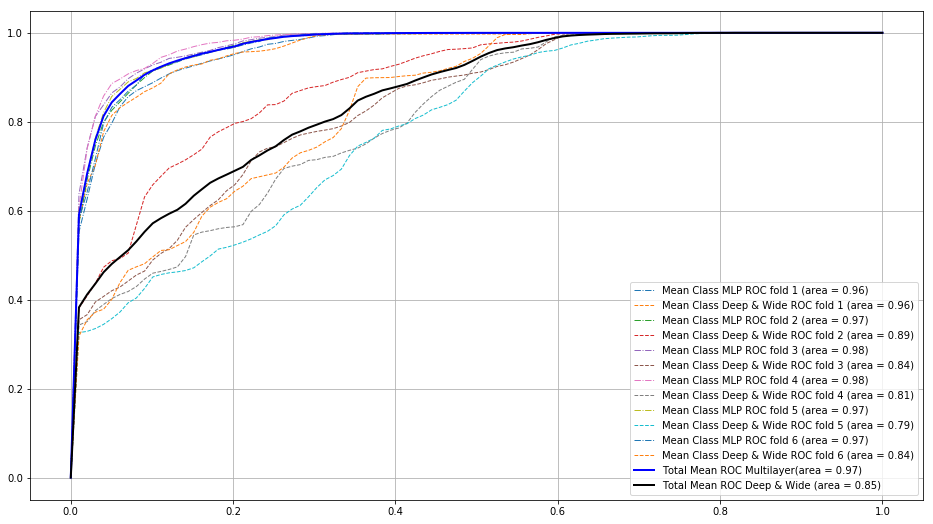

In [76]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.neural_network import MLPClassifier
plt.rcParams["figure.figsize"] = (16,9)

mean_tpr = 0.0
mean_tpr2 = 0.0
mean_fpr = np.linspace(0, 1, 100)
mean_fpr2= np.linspace(0,1,100)
all_tpr = []
all_tpr2 = []
i=0
K=6
for train_index, test_index in tscv.split(x,y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## multilayer perceptron
    mlf = MLPClassifier(hidden_layer_sizes=(50, 10))

    mlf.fit(X_train, y_train)
    yhat = mlf.predict_proba(X_test)
    ## deep & wide neural network
    yhatmodel = (model.predict(X_ints_test + [X_test.iloc[:,:9]]))
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train)
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_test,
                                         yhat[:,j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'-.',lw=1,label='Mean Class MLP ROC fold %d (area = %0.2f)'
                    % (i+1, roc_auc))
    # second plot with deep & wide network
    all_tpr.append(perclass_mean_tpr)
    roc_auc2=0
    perclass_mean_tpr2=0.0
    for j in classes:
        fpr2, tpr2, thresholds2 = roc_curve(y_test,
                                         yhatmodel[:,j],
                                         pos_label=j)
        perclass_mean_tpr2 += interp(mean_fpr2, fpr2, tpr2)
        perclass_mean_tpr2[0] = 0.0
        roc_auc2 += auc(fpr2, tpr2)

    perclass_mean_tpr2 /= len(classes)
    roc_auc2 /= len(classes)
    mean_tpr2 += perclass_mean_tpr2

    plt.plot(mean_fpr2,perclass_mean_tpr2,'--',lw=1,label='Mean Class Deep & Wide ROC fold %d (area = %0.2f)'
                % (i+1, roc_auc2))
    i+=1
    all_tpr2.append(perclass_mean_tpr2)
mean_tpr /= K
mean_auc = auc(mean_fpr, mean_tpr)
perclass_mean_tpr = all_tpr[0]
for i in range(1,len(all_tpr)):
    perclass_mean_tpr += all_tpr[i]
perclass_mean_tpr /= K
plt.plot(mean_fpr,perclass_mean_tpr,'b-',lw=2,label='Total Mean ROC Multilayer(area = %0.2f)'
                   % (mean_auc))

mean_tpr2 /= K
mean_auc2 = auc(mean_fpr2, mean_tpr2)
perclass_mean_tpr2 = all_tpr2[0]
for i in range(1,len(all_tpr2)):
    perclass_mean_tpr2 += all_tpr2[i]
perclass_mean_tpr2 /= K
plt.plot(mean_fpr2,perclass_mean_tpr2,'k-',lw=2,label='Total Mean ROC Deep & Wide (area = %0.2f)'
                   % (mean_auc2))
plt.legend(loc='best')
plt.grid()